# COURSE PROJECT: NEURAL NETWORKS FOR CLASSIFICATION

**SINH VIÊN 1**

Họ tên: Nguyễn Hoàng Khải Minh

MSSV: 22127267

<br>

**SINH VIÊN 2**

Họ tên: 

MSSV: 22127

<br>
(Cập nhật lần cuối: 23/11/2024)

## Import các thư viện cần thiết

In [3]:
import numpy as np
import os
import pickle
import tarfile
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## 1. Data preparation

In [4]:
def read_cifar():
    train_X = []
    train_Y = []

    for i in range (1, 6):
        with open(f'cifar-10-batches-py/data_batch_{i}', 'rb') as f:
            train_data = pickle.load(f, encoding='bytes')
            train_X.append((train_data[b'data']) / 255.0)
            train_Y.append(train_data[b'labels'])
    train_X = np.concatenate(train_X, axis=0)
    train_Y = np.concatenate(train_Y)
    
    with open('cifar-10-batches-py/test_batch', 'rb') as f:
        test_data = pickle.load(f, encoding='bytes')
        test_X = np.array(test_data[b'data']) / 255.0
        test_Y = np.array(test_data[b'labels'])

    return train_X, train_Y, test_X, test_Y


train_X, train_Y, test_X, test_Y = read_cifar()

print(f'Shape of train_X: {train_X.shape}, shape of train_y: {train_Y.shape}')
print(f'Shape of test_X:  {test_X.shape}, shape of test_y:  {test_Y.shape}')

Shape of train_X: (50000, 3072), shape of train_y: (50000,)
Shape of test_X:  (10000, 3072), shape of test_y:  (10000,)


In [5]:
print(f'Min of train_X: {train_X.min()}, max of train_X: {train_X.max()}')

Min of train_X: 0.0, max of train_X: 1.0


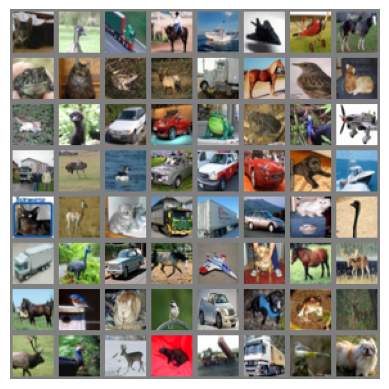

In [6]:
# Bạn có thể chạy cell này nhiều lần để xem các ảnh ngẫu nhiên khác nhau
n_rimages = 8; n_cimages = 8 
padding = 2 
canvas = 0.5 * np.ones((n_rimages * (32 + 2 * padding), n_cimages * (32 + 2 * padding), 3))
rand_idxs = np.random.permutation(np.arange(len(train_X))[:n_rimages * n_cimages])
for r in range(n_rimages):
    for c in range(n_cimages):
        i = r * n_cimages + c
        image = train_X[rand_idxs[i]].reshape(3, 32, 32).transpose(1, 2, 0)
        temp1 = r * (32 + 2 * padding) + padding 
        temp2 = c * (32 + 2 * padding) + padding 
        canvas[temp1:temp1 + 32, temp2:temp2 + 32, :] = image
plt.imshow(canvas, vmin=0, vmax=1)
plt.axis('off');

In [7]:
def load_meta(meta_file):
    with open(meta_file, 'rb') as f:
        meta_data = pickle.load(f, encoding='bytes')
    return meta_data[b'label_names']

# Ví dụ:
meta_file = 'cifar-10-batches-py/batches.meta'
label_names = load_meta(meta_file)

values, counts = np.unique(train_Y, return_counts=True)
for value, count in zip(values, counts):
    print(f'Value: {value} - {label_names[value].decode('utf-8')}, count: {count}')

Value: 0 - airplane, count: 5000
Value: 1 - automobile, count: 5000
Value: 2 - bird, count: 5000
Value: 3 - cat, count: 5000
Value: 4 - deer, count: 5000
Value: 5 - dog, count: 5000
Value: 6 - frog, count: 5000
Value: 7 - horse, count: 5000
Value: 8 - ship, count: 5000
Value: 9 - truck, count: 5000


In [8]:
def add_ones(X):
    return np.hstack((np.ones((len(X), 1)), X))

def one_hot(Y):
    K = np.max(Y) + 1
    y_onehot = np.zeros((len(Y), K))
    y_onehot[np.arange(len(Y)), Y] = 1
    return y_onehot

# Gọi hàm add_ones để tiền xử lý train_X
train_Z = add_ones(train_X)
print(f'Shape of train_Z: {train_Z.shape}')

# Gọi hàm one_hot để tiền xử lý train_Y
train_Y_onehot = one_hot(train_Y)
train_Y_onehot.shape
print(f'Shape of train_Y_onehot: {train_Y_onehot.shape}')


Shape of train_Z: (50000, 3073)
Shape of train_Y_onehot: (50000, 10)


## 2. Model Design

| Hyperparameter        | Value             |
|-----------------------|-------------------|
| Number of layers      | 2 hidden layers   |
| Neurons per layer     | 512               |
| Activation function   | ReLU              |
| Optimizer             | Adam              |
| Learning rate         | 0.001             |
| Weight decay          | 0.0001            |
| Epsilon               | 1e-7              |
| Epochs                | 100               |
| Batch size            | 200               |
| Loss function         | Cross-entropy     |
| Validation fraction   | 0.1               |
| Early stopping        | True              |

**SKLEARN**

In [146]:
# Number of layers: 2 hidden layers
# Neuron per layer: 512
# Activation function: ReLU (default)
# Optimizer: Adam (default)
# Learning rate: 0.001 (default)
# Weight decay: 0.0001 (default)
# epsilon: 1e-7 
# Epochs: 100
# Batch size: 200 (default)
# Loss function: Cross-entropy

def mlp_sklearn(X, y):
    from sklearn.neural_network import MLPClassifier
    model = MLPClassifier(
        hidden_layer_sizes=(128, 128), 
        max_iter=300, 
        alpha=0.0001,
        batch_size=128,
        solver='adam', 
        learning_rate_init=0.001,
        validation_fraction=0.1,
        early_stopping=True,
        n_iter_no_change=25,
        tol=0,
        verbose=True, 
    )
    model.fit(X, y)
    return model


In [175]:
def mlp_sklearn_custom_lr(X, y):
    from sklearn.neural_network import MLPClassifier
    # Số epochs cho mỗi chu kỳ
    epochs_per_cycle = 95
    total_epochs = 300
    initial_lr = 0.1
    
    # Tính số chu kỳ
    num_cycles = total_epochs // epochs_per_cycle

    # Mô hình MLPClassifier
    model = MLPClassifier(
        hidden_layer_sizes=(128, 128),
        activation='relu',
        alpha=0.001,
        solver='sgd',
        momentum=0,
        learning_rate_init=initial_lr,
        batch_size=128,
        validation_fraction=0.1,
        max_iter=epochs_per_cycle,
        verbose=True,
        warm_start=True  # Giữ lại trạng thái mô hình khi huấn luyện thêm
    )

    # Huấn luyện mô hình với giảm learning rate sau mỗi chu kỳ
    for cycle in range(num_cycles):
        print(f"\n=== Cycle {cycle+1}/{num_cycles} ===")
        model.learning_rate_init = initial_lr * (10 ** -cycle)  # Giảm lr xuống 10 lần mỗi chu kỳ
        print(f"Learning rate: {model.learning_rate_init}")
        model.fit(X, y)
    return model

In [176]:
# Huấn luyện mô hình
model_sklearn = mlp_sklearn_custom_lr(train_Z, train_Y)


=== Cycle 1/3 ===
Learning rate: 0.1
Iteration 1, loss = 1.98633357
Iteration 2, loss = 1.77869522
Iteration 3, loss = 1.69244389
Iteration 4, loss = 1.63531203
Iteration 5, loss = 1.58441725
Iteration 6, loss = 1.54997515
Iteration 7, loss = 1.52545989
Iteration 8, loss = 1.49125456
Iteration 9, loss = 1.47304547
Iteration 10, loss = 1.44753301
Iteration 11, loss = 1.42919027
Iteration 12, loss = 1.41152074
Iteration 13, loss = 1.39408150
Iteration 14, loss = 1.37804582
Iteration 15, loss = 1.36121931
Iteration 16, loss = 1.34402091
Iteration 17, loss = 1.33682117
Iteration 18, loss = 1.31837219
Iteration 19, loss = 1.31111395
Iteration 20, loss = 1.29312061
Iteration 21, loss = 1.27969419
Iteration 22, loss = 1.26981999
Iteration 23, loss = 1.26081662
Iteration 24, loss = 1.24805973
Iteration 25, loss = 1.23290211
Iteration 26, loss = 1.22890357
Iteration 27, loss = 1.22158818
Iteration 28, loss = 1.20677001
Iteration 29, loss = 1.19993743
Iteration 30, loss = 1.18709325
Iteration 3

c:\Users\MSI BRAVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (95) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.60480908
Iteration 2, loss = 0.57834521
Iteration 3, loss = 0.57120963
Iteration 4, loss = 0.56641887
Iteration 5, loss = 0.56244331
Iteration 6, loss = 0.55903022
Iteration 7, loss = 0.55598356
Iteration 8, loss = 0.55301680
Iteration 9, loss = 0.55032144
Iteration 10, loss = 0.54788932
Iteration 11, loss = 0.54565854
Iteration 12, loss = 0.54350314
Iteration 13, loss = 0.54121850
Iteration 14, loss = 0.53908450
Iteration 15, loss = 0.53709030
Iteration 16, loss = 0.53529190
Iteration 17, loss = 0.53281480
Iteration 18, loss = 0.53117164
Iteration 19, loss = 0.52944393
Iteration 20, loss = 0.52773901
Iteration 21, loss = 0.52588758
Iteration 22, loss = 0.52368114
Iteration 23, loss = 0.52193053
Iteration 24, loss = 0.52039854
Iteration 25, loss = 0.51923031
Iteration 26, loss = 0.51749904
Iteration 27, loss = 0.51540625
Iteration 28, loss = 0.51454661
Iteration 29, loss = 0.51235588
Iteration 30, loss = 0.51087943
Iteration 31, loss = 0.50887874
Iteration 32, los

c:\Users\MSI BRAVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (95) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.40991137
Iteration 2, loss = 0.40791123
Iteration 3, loss = 0.40758199
Iteration 4, loss = 0.40728905
Iteration 5, loss = 0.40716395
Iteration 6, loss = 0.40688580
Iteration 7, loss = 0.40688100
Iteration 8, loss = 0.40666976
Iteration 9, loss = 0.40658133
Iteration 10, loss = 0.40633054
Iteration 11, loss = 0.40612780
Iteration 12, loss = 0.40602835
Iteration 13, loss = 0.40597761
Iteration 14, loss = 0.40574715
Iteration 15, loss = 0.40568182
Iteration 16, loss = 0.40557176
Iteration 17, loss = 0.40542690
Iteration 18, loss = 0.40526094
Iteration 19, loss = 0.40504346
Iteration 20, loss = 0.40495722
Iteration 21, loss = 0.40483563
Iteration 22, loss = 0.40457614
Iteration 23, loss = 0.40447949
Iteration 24, loss = 0.40436651
Iteration 25, loss = 0.40427243
Iteration 26, loss = 0.40410155
Iteration 27, loss = 0.40398915
Iteration 28, loss = 0.40380924
Iteration 29, loss = 0.40370853
Iteration 30, loss = 0.40356755
Iteration 31, loss = 0.40341862
Iteration 32, los

c:\Users\MSI BRAVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (95) reached and the optimization hasn't converged yet.
  warnings.warn(


In [177]:
# Dự đoán
test_Z = add_ones(test_X)
test_Y_pred = model_sklearn.predict(test_Z)

# Tính độ chính xác
accuracy = accuracy_score(test_Y, test_Y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# In classification report
print(classification_report(test_Y, test_Y_pred, target_names=[label.decode('utf-8') for label in label_names]))

# In confusion matrix
cm = confusion_matrix(test_Y, test_Y_pred)
print(cm)

Accuracy: 51.65%
              precision    recall  f1-score   support

    airplane       0.59      0.59      0.59      1000
  automobile       0.62      0.60      0.61      1000
        bird       0.42      0.42      0.42      1000
         cat       0.34      0.37      0.35      1000
        deer       0.43      0.45      0.44      1000
         dog       0.42      0.41      0.41      1000
        frog       0.58      0.57      0.57      1000
       horse       0.56      0.56      0.56      1000
        ship       0.63      0.65      0.64      1000
       truck       0.59      0.55      0.57      1000

    accuracy                           0.52     10000
   macro avg       0.52      0.52      0.52     10000
weighted avg       0.52      0.52      0.52     10000

[[594  32  60  35  38  23  21  29 122  46]
 [ 45 600  30  29  13  21  12  26  78 146]
 [ 66  21 424 101 136  91  64  53  26  18]
 [ 28  19  79 369  80 194 114  60  27  30]
 [ 37  10 141  82 450  53  90  97  25  15]
 [ 35  11

**TENSORFLOW**

In [123]:
# Number of layers: 2 hidden layers
# Neuron per layer: 512
# Activation function: ReLU
# Optimizer: Adam
# Learning rate: 0.001 (default)
# Weight decay: 0.0001 
# epsilon: 1e-7 (default)
# Epochs: 100
# Batch size: 200
# Loss function: Cross-entropy

def mlp_tf(X, y):
    import tensorflow as tf
    from tensorflow.keras import layers, models
    model = models.Sequential([
        layers.Input(shape=(X.shape[1], )),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.1,
        decay_steps=95*(X.shape[0]*0.9//128),
        decay_rate=0.1,
        staircase=True
    )

    sgd = tf.keras.optimizers.SGD(learning_rate=lr_schedule, weight_decay=0.001)

    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        X, 
        y, 
        epochs=300, 
        batch_size=128, 
        validation_split=0.1,
        callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=15,
            min_delta=0,
            restore_best_weights=True,
            start_from_epoch=250
        )]
    )
    return model, history

In [127]:
# Huấn luyện mô hình
model_tf, history_tf = mlp_tf(train_Z, train_Y_onehot)


Epoch 1/300
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2175 - loss: 2.1219 - val_accuracy: 0.3042 - val_loss: 1.8795
Epoch 2/300
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3407 - loss: 1.8225 - val_accuracy: 0.3788 - val_loss: 1.7282
Epoch 3/300
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3837 - loss: 1.7285 - val_accuracy: 0.3852 - val_loss: 1.7158
Epoch 4/300
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4043 - loss: 1.6626 - val_accuracy: 0.3654 - val_loss: 1.8621
Epoch 5/300
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4136 - loss: 1.6352 - val_accuracy: 0.4030 - val_loss: 1.6855
Epoch 6/300
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4339 - loss: 1.5913 - val_accuracy: 0.4276 - val_loss: 1.5969
Epoch 7/300
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4413 - loss: 1.5574 - val_accuracy: 0.4076 - val_loss: 1.6571
Epoch 8/300
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4441 - loss: 1.5507 - val_accu

In [128]:
# Dự đoán
test_Z = add_ones(test_X)
test_Y_pred = model_tf.predict(test_Z)
test_Y_pred = np.argmax(test_Y_pred, axis=1)

# Tính độ chính xác
accuracy = accuracy_score(test_Y, test_Y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# In classification report
print(classification_report(test_Y, test_Y_pred, target_names=[label.decode('utf-8') for label in label_names]))

# In confusion matrix
cm = confusion_matrix(test_Y, test_Y_pred)
print(cm)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 54.73%
              precision    recall  f1-score   support

    airplane       0.61      0.62      0.61      1000
  automobile       0.67      0.65      0.66      1000
        bird       0.44      0.43      0.44      1000
         cat       0.38      0.39      0.38      1000
        deer       0.48      0.48      0.48      1000
         dog       0.46      0.45      0.45      1000
        frog       0.59      0.60      0.59      1000
       horse       0.62      0.59      0.61      1000
        ship       0.66      0.67      0.67      1000
       truck       0.58      0.60      0.59      1000

    accuracy                           0.55     10000
   macro avg       0.55      0.55      0.55     10000
weighted avg       0.55      0.55      0.55     10000

[[618  32  55  16  37  17  21  26 123  55]
 [ 33 648  13  24  10  15  14  22  54 167]
 [ 66  21 434  96 130  76  80  53  17  27]
 [ 26  22  92 387  69 201 103  46  21  33]
 [ 47   8 1

**PYTORCH**

In [168]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

def train_mlp_pytorch(X, y, epochs=300, batch_size=128, patience=15, start_from_epoch=250):
    # Convert data to PyTorch tensors
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)
    
    # Split data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model, loss, and optimizer
    input_size = X.shape[1]
    output_size = 10
    model = MLP(input_size, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=0.001)

    # Learning rate scheduler
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=95, gamma=0.1)

    # Training loop
    best_val_loss = float('inf')
    patience_counter = 0
    history = {"train_loss": [], "val_loss": [], "val_accuracy": []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        
        train_loss /= len(train_loader.dataset)
        history["train_loss"].append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                preds = outputs.argmax(dim=1)
                correct += (preds == y_batch).sum().item()
        
        val_loss /= len(val_loader.dataset)
        val_accuracy = correct / len(val_loader.dataset)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_accuracy)
        
        # Early stopping
        if epoch >= start_from_epoch:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), "best_model.pth")
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
        
        # Update learning rate
        lr_scheduler.step()

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, "
              f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Load the best model
    model.load_state_dict(torch.load("best_model.pth"))
    
    return model, history


# Dự đoán
def evaluate_model(model, test_X, test_Y, label_names):
    model.eval()  # Đặt mô hình ở chế độ đánh giá
    with torch.no_grad():  # Tắt tính toán gradient
        # Thêm cột 1s (nếu cần)
        test_Z = torch.tensor(test_X, dtype=torch.float32)  # Convert test_X to PyTorch tensor
        
        # Dự đoán xác suất
        outputs = model(test_Z)
        
        # Lấy nhãn dự đoán (argmax trên xác suất)
        test_Y_pred = outputs.argmax(dim=1).numpy()  # Chuyển về numpy array
    
    # Tính độ chính xác
    accuracy = accuracy_score(test_Y, test_Y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    
    # In classification report
    print(classification_report(test_Y, test_Y_pred, target_names=[label.decode('utf-8') for label in label_names]))
    
    # In confusion matrix
    cm = confusion_matrix(test_Y, test_Y_pred)
    print(cm)


In [169]:
# Huấn luyện mô hình
model_pytorch, hystory_pytorch = train_mlp_pytorch(train_Z, train_Y)

Epoch 1/300, Train Loss: 2.2819, Val Loss: 2.2429, Val Accuracy: 0.2084, Learning Rate: 0.100000
Epoch 2/300, Train Loss: 2.2048, Val Loss: 2.1890, Val Accuracy: 0.2622, Learning Rate: 0.100000
Epoch 3/300, Train Loss: 2.1732, Val Loss: 2.1833, Val Accuracy: 0.2714, Learning Rate: 0.100000
Epoch 4/300, Train Loss: 2.1579, Val Loss: 2.1546, Val Accuracy: 0.2980, Learning Rate: 0.100000
Epoch 5/300, Train Loss: 2.1427, Val Loss: 2.1394, Val Accuracy: 0.3154, Learning Rate: 0.100000
Epoch 6/300, Train Loss: 2.1254, Val Loss: 2.1303, Val Accuracy: 0.3268, Learning Rate: 0.100000
Epoch 7/300, Train Loss: 2.1130, Val Loss: 2.1364, Val Accuracy: 0.3172, Learning Rate: 0.100000
Epoch 8/300, Train Loss: 2.1039, Val Loss: 2.1122, Val Accuracy: 0.3462, Learning Rate: 0.100000
Epoch 9/300, Train Loss: 2.0982, Val Loss: 2.1079, Val Accuracy: 0.3442, Learning Rate: 0.100000
Epoch 10/300, Train Loss: 2.0913, Val Loss: 2.1124, Val Accuracy: 0.3412, Learning Rate: 0.100000
Epoch 11/300, Train Loss: 2.0

C:\Users\MSI BRAVO\AppData\Local\Temp\ipykernel_24344\4119980530.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


In [170]:
# Dự đoán
evaluate_model(model_pytorch, test_Z, test_Y, label_names)


Accuracy: 51.83%
              precision    recall  f1-score   support

    airplane       0.59      0.57      0.58      1000
  automobile       0.63      0.64      0.63      1000
        bird       0.41      0.31      0.35      1000
         cat       0.36      0.36      0.36      1000
        deer       0.47      0.44      0.45      1000
         dog       0.43      0.35      0.39      1000
        frog       0.51      0.65      0.57      1000
       horse       0.56      0.59      0.57      1000
        ship       0.60      0.68      0.64      1000
       truck       0.57      0.60      0.58      1000

    accuracy                           0.52     10000
   macro avg       0.51      0.52      0.51     10000
weighted avg       0.51      0.52      0.51     10000

[[571  40  49  27  29  19  23  30 152  60]
 [ 36 636   7  29  14  23  25  24  69 137]
 [ 86  33 310  94 132  73 131  83  34  24]
 [ 33  26  67 356  55 165 144  64  35  55]
 [ 62  18 120  55 441  38 129  95  30  12]
 [ 20  13

## Evaluation